<a href="https://colab.research.google.com/github/jsblandon/sdm_py/blob/main/raster_align_for_sdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Instalación de paquetes**

In [ ]:
%%capture

# Retrieving tile maps from the internet
!pip3 install contextily

# geospatial xarray extension powered by rasterio
!pip install rioxarray

# Utilities for applying scikit-learn to spatial datasets
!pip install pyimpute

# Plot data on map projections with matplotlib
!python -m pip install basemap

# A Python library for making geographic flat-top hexagon grids like QGIS's `create grid` function
!pip install geohexgrid

# Artist for matplotlib to display a scale bar
!pip install matplotlib-scalebar

In [ ]:
# Se importan funciones auxiliares desde GitHub requeridas para el desarrollo de
# este práctico
!git clone https://github.com/jsblandon/weather_data_uy_preprocessing.git
import sys
sys.path.append('/content/weather_data_uy_preprocessing')

Cloning into 'weather_data_uy_preprocessing'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 4.80 KiB | 4.80 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## **Carga de Librerías**

In [ ]:
# Se importan las librerías necesarias
import contextily as cx            # basemap tiles
import geopandas as gpd
import geohexgrid as ghg           # hexagon grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr                # labelled multi-dimensional arrays
import rasterio as rio             # rastewr managing
import rioxarray as rxr            # raster managing
from matplotlib_scalebar.scalebar import ScaleBar
from geopandas import GeoDataFrame # to create GeoPandas DataFrames
from google.colab import files, drive
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from pyimpute import load_training_vector
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from shapely.geometry import mapping, Point, Polygon # for clipping rasters using shapes and geometries managing
from weather_data_preprocessing import null_report

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set_style('whitegrid')

## **Carga de Funciones**

In [ ]:
def generate_hex_ab_counts(gdf_av : GeoDataFrame, gdf_hex : GeoDataFrame, var : str )-> GeoDataFrame:
    f"""Funcion para sumar abundancias por hexagonos

    Recibe
    ------
        gdf_av : GeoDataFrame
            Debe tener la geometría, un identificador de la celda y la columna
            de a sumar

        gdf_hex : GeoDataFrame
            Contiene los polígonos de los hexagonos

        var : string
            Variable sobre la cual se desea hacer el conteo

    Devuelve
    --------
        gdf : GeoDataFrame
            Entrega también un geodataframe con los mismos campos pero para todas
            las celdas de la malla hexagonal

        Fuente: J.S. Blandon (2024).
    """
    gdf = gdf_av.groupby(['geometry','cell_id'])[var].sum().reset_index()
    gdf = pd.merge(gdf_hex, gdf, how= "outer", on= "cell_id")
    gdf = GeoDataFrame(gdf, crs= '5382', geometry= gdf['geometry_x'])
    gdf.drop(['geometry_x','geometry_y'],axis= 1, inplace= True)
    # gdf[var] = np.log1p(gdf[var].fillna(0))

    return gdf

In [ ]:
def data_imputation(gdf_av : GeoDataFrame, ruta_raster : list, crs_raster : str, etiqueta : str, var_list : list)-> GeoDataFrame:
    f"""Funcion para prepararacion de variables exogenas para alimentar SDMs

    Recibe
    ------
        gdf_av : GeoDataFrame
            Debe tener la geometría y la columna de las etiquetas (presencia/ausencia)

        ruta_raster : list
            Lista con las rutas o única ruta de los rasters a utilizar

        crs_raster : str
            CRS del raster

        etiqueta : string
            Variable que identifica las presencias/ausencias

        var_list : list
            Lista de nombres para asignarle a las variables imputadas

    Devuelve
    --------
        gdf : GeoDataFrame
            Entrega un GeoDataFrame con las variables exogenas indexadas

        Fuente: J.S. Blandon (2024).
    """

    # Se hace una copia del GeoDataFrame de malla hexagonal que contiene los datos
    gdf_av_copy = gdf_av.copy()

    # Se reemplaza la geometría por el centroide de los hexagonos
    gdf_av_copy['geometry'] = gdf_av_copy['geometry'].centroid

    # Se reproyecta el GeoDataframe a la capa raster
    gdf_av_copy = gdf_av_copy.to_crs(crs_raster)

    # Se carga el vector
    var_vals, _ = load_training_vector(gdf_av_copy,
                                       ruta_raster,
                                       response_field=etiqueta)

    # Se indexan el raster imputado al GeoDataFrame
    if len(var_list) == 1:
        gdf_av_copy[var_list[0]] = var_vals.reshape(-1,)

    else:
        for i in range(len(var_list)):
            gdf_av_copy[var_list[i]] = var_vals[:,i].reshape(-1,)


    return gdf_av_copy

## **Carga de Datos**

### **Avistamientos**

In [ ]:
# Ruta de los datos de avistamientos
path = "/content/drive/MyDrive/research/codes/Proyecto aplicado /Procesamiento variables exogenas/filtered_df_final2.csv"

In [ ]:
# Carga de datos de avistamientos
df_cr =  pd.read_csv(path,parse_dates=["last_edited_date","observation_date"])

In [ ]:
# Variables clasificadas por el tipo de dato equivalente entre Python y R

char_attributes = ["checklist_id","country","country_code","state","state_code",
                   "locality","locality_id","locality_type","observer_id",
                   "sampling_event_identifier","protocol_type","protocol_code",
                   "project_code","group_identifier","trip_comments","scientific_name",
                   "time_observations_started"]

float_attributes= ["latitude","longitude","effort_distance_km",
                   "effort_hours","effort_speed_kmph","hours_of_day","year",
                   "day_of_year"]

int_attributes  = ["duration_minutes","number_observers","observation_count"]

bool_attributes = ["all_species_reported","species_observed"]

In [ ]:
# Conversion a tipos de datos string (cadenas)
df_cr[char_attributes] = df_cr[char_attributes].astype(str)

# Conversion a tipos de datos float (flotantes)
df_cr[float_attributes] = df_cr[float_attributes].astype(float)

# Conversion a tipos de datos integer (enteros)
df_cr[int_attributes] = df_cr[int_attributes].astype(int)

# Conversion a tipos de datos boolean (booleanos)
df_cr[bool_attributes] = df_cr[bool_attributes].astype(bool)

In [ ]:
# De DataFrame a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_cr['longitude'], df_cr['latitude'])]
gdf_df_cr = GeoDataFrame(df_cr, crs='WGS84', geometry=geometry)

In [ ]:
# Selección de Variables de interés a partir del GeoDataFrame de avistamientos
gdf_df_cr = gdf_df_cr[["scientific_name", "year", "latitude","longitude",
                       "observation_count", "geometry","effort_hours",'effort_speed_kmph',
                       'effort_distance_km', 'number_observers']]

In [ ]:
# Se transforman los datos a una representacion basada en Unidades Estándar
gdf_df_cr = gdf_df_cr.to_crs(epsg = 5382)

### **Shape de Departamentos de Colombia**

In [ ]:
# Carga de Shape complementario
dir_Drive_shp = "/content/drive/MyDrive/research/codes/Proyecto aplicado /Departamentos_Junio_2024_shp/Departamento.shp"

states = gpd.read_file(dir_Drive_shp, use_arrow=True)

# Conversion al Sistema de Referencia de Coordendas
states = states.to_crs(crs=gdf_df_cr.crs)

# Region de Interés
roi = states[states['DeNombre'] == 'Risaralda']

# Reproyección
roi = roi.to_crs(crs=gdf_df_cr.crs)

### **Variables Exógenas: Elevación**

In [ ]:
# Ruta de los datos
ruta_var_exogenas = "/content/drive/MyDrive/research/codes/Proyecto aplicado /Variables Bioclimaticas/"

# CRS de los rasters de WorldClim
wc21_crs = rio.open(ruta_var_exogenas + "Elevation_Output_ris/elevation_1.tif").crs

### **Variables Exógenas: MapBiomas**

In [ ]:
# Carga del raster
mapbiomas_ris = rxr.open_rasterio(ruta_var_exogenas + "MapBiomas_Output_ris/mapbiomas_ris_2014.tif", masked = True).squeeze()
mb_crs = rio.open(ruta_var_exogenas + "MapBiomas_Output_ris/mapbiomas_ris_2014.tif").crs

## **Código Principal**

In [ ]:
roi.crs

<Projected CRS: EPSG:5382>
Name: SIRGAS-ROU98 / UTM zone 21S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Uruguay - west of 54°W, onshore and offshore.
- bounds: (-58.49, -36.63, -54.0, -30.09)
Coordinate Operation:
- name: UTM zone 21S
- method: Transverse Mercator
Datum: SIRGAS-ROU98
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Se grafican los datos
fig, axs = plt.subplots(1, 1, figsize=(10, 10), sharey=True, sharex=True)

gdf_df_cr.plot(ax=axs,c='b',markersize=8)
roi.plot(ax=axs,facecolor='none',edgecolor='k')
cx.add_basemap(ax=axs,crs=gdf_df_cr.crs,attribution_size=3)

axs.add_artist(ScaleBar(1))

plt.title("Registros Risaralda Henicorhina negreti", fontsize=22)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

In [ ]:
# A partir del shape de la Región de Interés se genera una malla hexagonal
roi_hexagrid = ghg.make_grid_from_gdf(roi, R=500)

In [ ]:
# Recorte del shape
roi_hexagrid = gpd.clip(roi_hexagrid,roi)

In [ ]:
# Gráfica de la representacion hexagonal
fig, axs = plt.subplots(1, 1, figsize=(10, 10), sharey=True, sharex=True)

roi_hexagrid.plot(ax=axs,facecolor='black',linewidth=1.5)
gdf_df_cr.plot(ax=axs,c='b',markersize=8)
cx.add_basemap(ax=axs,crs=roi_hexagrid.crs,attribution_size=3)

axs.add_artist(ScaleBar(1))

plt.suptitle("Representacion de malla hexagonal", fontsize=22)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

In [ ]:
# Se une la información de la malla hexagonal a los datos
malla_avist_cr = gpd.sjoin(roi_hexagrid, gdf_df_cr, how="inner", predicate="contains")

In [ ]:
malla_avist_cr

cell_id                                           geometry  \
750    -2121,24359  POLYGON ((-1591000 10547323.393, -1591250 1054...   
882    -2118,24360  POLYGON ((-1589000 10548189.418, -1588750 1054...   
885    -2115,24361  POLYGON ((-1586750 10548622.431, -1586500 1054...   
878    -2122,24360  POLYGON ((-1592000 10548189.418, -1591750 1054...   
878    -2122,24360  POLYGON ((-1592000 10548189.418, -1591750 1054...   
...            ...                                                ...   
14499  -2175,24573  POLYGON ((-1630750 10640421.124, -1631000 1063...   
14499  -2175,24573  POLYGON ((-1630750 10640421.124, -1631000 1063...   
14499  -2175,24573  POLYGON ((-1630750 10640421.124, -1631000 1063...   
14499  -2175,24573  POLYGON ((-1630750 10640421.124, -1631000 1063...   
14499  -2175,24573  POLYGON ((-1630750 10640421.124, -1631000 1063...   

       index_right      scientific_name    year  latitude  longitude  \
750          17038  Henicorhina negreti  2018.0  4.701116 -75.521315   
882          16453  Henicorhina negreti  2018.0  4.703466 -75.500879   
885           9808  Henicorhina negreti  2018.0  4.707334 -75.487361   
878           1171  Henicorhina negreti  2020.0  4.699431 -75.529094   
878          17037  Henicorhina negreti  2018.0  4.699931 -75.530951   
...            ...                  ...     ...       ...        ...   
14499        15695  Henicorhina negreti  2023.0  5.480582 -75.896344   
14499        14203  Henicorhina negreti  2023.0  5.480582 -75.896344   
14499        14202  Henicorhina negreti  2023.0  5.480582 -75.896344   
14499        14200  Henicorhina negreti  2023.0  5.480582 -75.896344   
14499        14198  Henicorhina negreti  2023.0  5.480582 -75.896344   

       observation_count  effort_hours  effort_speed_kmph  effort_distance_km  \
750                    0      1.283333           1.253766               1.609   
882                    0      2.166667           0.923077               2.000   
885                    0      0.333333           0.900000               0.300   
878                    0      0.766667           1.200000               0.920   
878                    0      0.883333           2.551698               2.254   
...                  ...           ...                ...                 ...   
14499                  0      1.966667           0.091525               0.180   
14499                  0      0.633333           0.584211               0.370   
14499                  0      1.433333           0.439535               0.630   
14499                  0      1.466667           0.600000               0.880   
14499                  0      2.216667           0.830075               1.840   

       number_observers  
750                   2  
882                   3  
885                   2  
878                   1  
878                   2  
...                 ...  
14499                 3  
14499                 1  
14499                 1  
14499                 1  
14499                 1  

[19163 rows x 12 columns]

In [ ]:
# Conteo de variables de esfuerzo y avistamientos por hexagono
variables = ["effort_speed_kmph", 'effort_hours', 'effort_distance_km',
             'number_observers']

malla_avist_cr_ev = generate_hex_ab_counts(malla_avist_cr,roi_hexagrid,'observation_count')

for var in variables:
    gdf_temp = generate_hex_ab_counts(malla_avist_cr,roi_hexagrid,var)
    malla_avist_cr_ev = pd.merge(malla_avist_cr_ev, gdf_temp.drop(columns='geometry'),
                                    how= "outer", on= "cell_id")

In [ ]:
# Malla de avistamientos
malla_avist_cr_ev.fillna(0, inplace= True)

In [ ]:
# Se crea la columna de etiquetas
malla_avist_cr_ev['label'] = malla_avist_cr_ev['observation_count'].apply(lambda x: 1 if x > 0 else 0)

# A manera de visualización se prueba si se asignaron correctamente las etiquetas
malla_avist_cr_ev[['label','observation_count']][malla_avist_cr_ev['observation_count'] != 0]

label  observation_count
3321      1                1.0
3335      1               14.0
3413      1               36.0
3467      1                4.0
3494      1                3.0
3646      1               11.0
4656      1                3.0
4842      1                2.0
5843      1                1.0
5953      1                9.0
5959      1                5.0
5997      1                4.0
6002      1                2.0
6036      1                8.0
6041      1                2.0
6081      1              202.0
6082      1                6.0
6120      1              280.0
6121      1                8.0
6157      1              832.0
6158      1                4.0

In [ ]:
# Se aplica función personalizada para imputar espacialmente los datos a partir
# del GeoDataFrame de avistamiento

# Rutas de las variables exógenas: WorldClim + Elevación
rutas_vars_exogenas = [ruta_var_exogenas + "Elevation_Output_ris/elevation_1.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_1.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_2.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_3.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_4.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_5.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_6.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_7.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_8.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_9.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_10.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_11.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_12.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_13.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_14.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_15.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_16.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_17.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_18.tif",
                       ruta_var_exogenas + "WorldClim_Output_ris/worldclim_bio_19.tif"
                       ]

# Lista de nombres de las nuevas variables
var_list = ['elevation','anual_mean_t', 'mean_diurnal_range',
            'isothermality', 't_seasonality', 'max_t_warmest_month',
            'min_t_coldest_month', 't_annual_range', 'mean_t_wettest_q',
            'mean_t_driest_q','mean_t_warmest_q','mean_t_coldest_q','annual_p',
            'p_wettest_m','p_driest_m', 'p_seasonality', 'p_wettest_q',
            'p_driest_q', 'p_warmest_q', 'p_coldest_q']

# Se imputan las nuevas variables al GeoDataFrame
malla_avist_cr_ev = data_imputation(malla_avist_cr_ev,
        rutas_vars_exogenas,
        wc21_crs,
        'label',
        var_list)

In [ ]:
malla_avist_cr_ev

cell_id  observation_count                   geometry  \
0     -2098,24366                0.0   POINT (-75.3791 4.72945)   
1     -2098,24374                0.0   POINT (-75.3794 4.76105)   
2     -2098,24376                0.0  POINT (-75.37983 4.76657)   
3     -2098,24378                0.0  POINT (-75.37998 4.77227)   
4     -2098,24380                0.0  POINT (-75.37935 4.78099)   
...           ...                ...                        ...   
6481  -2224,24542                0.0  POINT (-76.20093 5.35628)   
6482  -2224,24544                0.0  POINT (-76.20126 5.36429)   
6483  -2224,24546                0.0  POINT (-76.20088 5.36786)   
6484  -2225,24539                0.0  POINT (-76.20753 5.34678)   
6485  -2225,24541                0.0  POINT (-76.20546 5.35125)   

      effort_speed_kmph  effort_hours  effort_distance_km  number_observers  \
0                 0.000           0.0                0.00               0.0   
1                 0.000           0.0                0.00               0.0   
2                 0.000           0.0                0.00               0.0   
3                 0.000           0.0                0.00               0.0   
4                 0.000           0.0                0.00               0.0   
...                 ...           ...                 ...               ...   
6481              1.575           6.4                4.13              15.0   
6482              0.000           0.0                0.00               0.0   
6483              0.000           0.0                0.00               0.0   
6484              0.000           0.0                0.00               0.0   
6485              0.000           0.0                0.00               0.0   

      label elevation anual_mean_t  ... mean_t_warmest_q mean_t_coldest_q  \
0         0    4294.0     3.497833  ...            3.758         3.292667   
1         0    4249.0        3.748  ...            4.006         3.550667   
2         0    4249.0        3.748  ...            4.006         3.550667   
3         0    4249.0        3.748  ...            4.006         3.550667   
4         0    4249.0        3.748  ...            4.006         3.550667   
...     ...       ...          ...  ...              ...              ...   
6481      0     435.0    25.054001  ...        25.415333           24.608   
6482      0     435.0    25.054001  ...        25.415333           24.608   
6483      0     435.0    25.054001  ...        25.415333           24.608   
6484      0     435.0    25.054001  ...        25.415333           24.608   
6485      0     435.0    25.054001  ...        25.415333           24.608   

     annual_p p_wettest_m p_driest_m p_seasonality p_wettest_q p_driest_q  \
0      1204.0       154.0       42.0     33.198063       402.0      185.0   
1      1242.0       159.0       44.0     33.470444       404.0      186.0   
2      1242.0       159.0       44.0     33.470444       404.0      186.0   
3      1242.0       159.0       44.0     33.470444       404.0      186.0   
4      1242.0       159.0       44.0     33.470444       404.0      186.0   
...       ...         ...        ...           ...         ...        ...   
6481   3403.0       428.0      159.0     30.314732      1175.0      598.0   
6482   3403.0       428.0      159.0     30.314732      1175.0      598.0   
6483   3403.0       428.0      159.0     30.314732      1175.0      598.0   
6484   3403.0       428.0      159.0     30.314732      1175.0      598.0   
6485   3403.0       428.0      159.0     30.314732      1175.0      598.0   

     p_warmest_q p_coldest_q  
0          349.0       268.0  
1          373.0       279.0  
2          373.0       279.0  
3          373.0       279.0  
4          373.0       279.0  
...          ...         ...  
6481       868.0      1175.0  
6482       868.0      1175.0  
6483       868.0      1175.0  
6484       868.0      1175.0  
6485       868.0      1175.0  

[6485 rows x 28 columns]

In [ ]:
malla_avist_cr_ev.dropna(inplace=True)

In [ ]:
# Se aplica función personalizada para imputar espacialmente los datos a partir
# del GeoDataFrame de avistamiento

# Rutas de las variables exógenas: MapBiomas
rutas_vars_exogenas = [ruta_var_exogenas + "MapBiomas_Output_ris/mapbiomas_ris_2014.tif",
                       ruta_var_exogenas + "MapBiomas_Output_ris/mapbiomas_ris_2015.tif",
                       ruta_var_exogenas + "MapBiomas_Output_ris/mapbiomas_ris_2016.tif",
                       ruta_var_exogenas + "MapBiomas_Output_ris/mapbiomas_ris_2017.tif",
                       ruta_var_exogenas + "MapBiomas_Output_ris/mapbiomas_ris_2018.tif",
                       ruta_var_exogenas + "MapBiomas_Output_ris/mapbiomas_ris_2019.tif",
                       ruta_var_exogenas + "MapBiomas_Output_ris/mapbiomas_ris_2020.tif"]

# Lista de nombres de las nuevas variables
var_list = ['lulc_2014','lulc_2015','lulc_2016','lulc_2017','lulc_2018','lulc_2019','lulc_2020']

# Se imputan las nuevas variables al GeoDataFrame
malla_avist_cr_ev = data_imputation(malla_avist_cr_ev,
        rutas_vars_exogenas,
        mb_crs,
        'label',
        var_list)

In [ ]:
# Se hace una copia del GeoDataFrame
malla_avist_cr_ev_mb = malla_avist_cr_ev.copy()

In [ ]:
# Se guardael GeoDataFrame para no tener que correr de nuevo el código anterior
malla_avist_cr_ev_mb.to_file('/content/drive/MyDrive/research/codes/Proyecto aplicado /datos_unidos_avist_mb_ris.shp')

<ipython-input-51-5a0b5f75d4ec>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  malla_avist_cr_ev_mb.to_file('/content/drive/MyDrive/research/codes/Proyecto aplicado /datos_unidos_avist_mb_ris.shp')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'observation_count' to 'observatio'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'effort_speed_kmph' to 'effort_spe'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'effort_hours' to 'effort_hou'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'effort_distance_km' to 'effort_dis'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'number

In [ ]:
# Estas columnas se descartan si ya tienen la información de estas variables en
# el GeoDataFrame de las variables de WorldClim + Elevacion
malla_avist_cr_ev_mb.drop(columns=['observation_count', 'effort_speed_kmph',
                                   'effort_hours','effort_distance_km',
                                   'number_observers', 'label'], inplace = True)

In [ ]:
# Se unen los datos de WorldClim + Elevacion con los de MapBiomas para el departamento
malla_avist_cr_ev_f = gpd.sjoin(malla_avist_cr_ev, malla_avist_cr_ev_mb,on_attribute='cell_id')

In [ ]:
# Se almacena el shapefile.
# CUIDADO YA QUE LAS VARIABLES SE LES RECORTARÁ EL NOMBRE POR LA LIBRERÍA QUE
# GUARDA LOS DATOS
malla_avist_cr_ev_f.to_file('/content/drive/MyDrive/research/codes/Proyecto aplicado /datos_unidos_avist_wc_mb_ris.shp')

<ipython-input-66-1c0138431926>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  malla_avist_cr_ev_f.to_file('/content/drive/MyDrive/research/codes/Proyecto aplicado /datos_unidos_avist_wc_mb_ris.shp')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'observation_count' to 'observatio'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'effort_speed_kmph' to 'effort_spe'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'effort_hours' to 'effort_hou'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'effort_distance_km' to 'effort_dis'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'numb

In [ ]:
# Carga del Shape de las variables WorldClim + Elevacion + Esfuerzo + MapBiomas
dir_Drive_shp = "/content/drive/MyDrive/research/codes/Proyecto aplicado /datos_unidos_avist_wc_mb_ris/datos_unidos_avist_wc_mb_ris.shp"

gdf_mb_ev_elv_wc = gpd.read_file(dir_Drive_shp, use_arrow=True)

In [ ]:
# CUIDADO QUE LAS COLUMNAS DEBEN RENOMBRARLAS CON LOS NOMBRES ANTES DE GUARDAR LOS
# DATOS PARA EVITAR PROBLEMAS DE VISUALIZACIÓN DE LOS NOMBRES. ADAPTEN ESTE
# CÓDIGO PARA QUE LAS COLUMNAS LAS RENOMBREN A SU CONSIDERACIÓN
gdf_mb_ev_elv_wc.columns

Index(['cell_id', 'observatio', 'effort_spe', 'effort_hou', 'effort_dis',
       'number_obs', 'label', 'elevation', 'anual_mean', 'mean_diurn',
       'isothermal', 't_seasonal', 'max_t_warm', 'min_t_cold', 't_annual_r',
       'mean_t_wet', 'mean_t_dri', 'mean_t_war', 'mean_t_col', 'annual_p',
       'p_wettest_', 'p_driest_m', 'p_seasonal', 'p_wettes_1', 'p_driest_q',
       'p_warmest_', 'p_coldest_', 'index_righ', 'lulc_2014', 'lulc_2015',
       'lulc_2016', 'lulc_2017', 'lulc_2018', 'lulc_2019', 'lulc_2020',
       'geometry'],
      dtype='object')

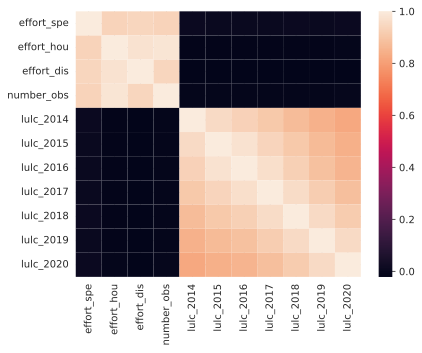

In [ ]:
# Plotting correlation heatmap
sns.heatmap(gdf_mb_ev_elv_wc[['effort_spe', 'effort_hou', 'effort_dis',
       'number_obs', 'elevation', 'anual_mean', 'mean_diurn',
       'isothermal', 't_seasonal', 'max_t_warm', 'min_t_cold', 't_annual_r',
       'mean_t_wet', 'mean_t_dri', 'mean_t_war', 'mean_t_col', 'annual_p',
       'p_wettest_', 'p_driest_m', 'p_seasonal', 'p_wettes_1', 'p_driest_q',
       'p_warmest_', 'p_coldest_', 'lulc_2014', 'lulc_2015',
       'lulc_2016', 'lulc_2017', 'lulc_2018', 'lulc_2019', 'lulc_2020']].corr(numeric_only=True))

# Displaying heatmap
plt.show()